We start the project by importing the necessary libraries and modules. Additionally, we load the dataset and clean it by utilizing only the initially identified features and dropping rows with null values. Furthermore, we merge the features 'Members with age less than 5 years old' and 'Members with age 5 - 17 years old' to create the 'Number of Children' feature.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector
import matplotlib.pyplot as plt
import category_encoders as ce

df_dataset = pd.read_csv('Family Income and Expenditure.csv')

# Initial features to use
features = [
    "Housing and water Expenditure",
    "Total Household Income",
    "Region",
    "Agricultural Household indicator",
    "Imputed House Rental Value",
    "Total Income from Entrepreneurial Acitivites",
    "Total Number of Family members",
    "Members with age less than 5 year old",
    "Members with age 5 - 17 years old",
    "Total number of family members employed",
    "Type of Building/House",
    "Type of Roof",
    "Type of Walls",
    "House Floor Area",
    "House Age",
    "Number of bedrooms",
    "Electricity",
    "Main Source of Water Supply",
    "Number of Television",
    "Number of CD/VCD/DVD",
    "Number of Component/Stereo set",
    "Number of Refrigerator/Freezer",
    "Number of Washing Machine",
    "Number of Airconditioner",
    "Number of Personal Computer"
]

df_temp = df_dataset.filter(features, axis=1)

df_temp.dropna(inplace=True)

df_temp['Number of Children'] = df_temp['Members with age less than 5 year old'] + df_temp['Members with age 5 - 17 years old']

df_temp = df_temp.drop(['Members with age less than 5 year old', 'Members with age 5 - 17 years old'], axis=1)

Next, we will identify the list of unique categories for three categorical features: Region, Type of Building/House, and Main Source of Water Supply. Note that this step is necessary since, as we will see later, these three features are included in the final Regression Model.

In [2]:
region_names = list(df_temp['Region'].unique())
print(f'Regions: {region_names}') # output: ['CAR', 'Caraga', 'VI - Western Visayas', 'V - Bicol Region', ' ARMM', 'III - Central Luzon', 'II - Cagayan Valley', 'IVA - CALABARZON', 'VII - Central Visayas', 'X - Northern Mindanao', 'XI - Davao Region', 'VIII - Eastern Visayas', 'I - Ilocos Region', 'NCR', 'IVB - MIMAROPA', 'XII - SOCCSKSARGEN', 'IX - Zasmboanga Peninsula']

house_types = list(df_temp['Type of Building/House'].unique())
print(f'Type of Building/House: {house_types}') # output : ['Single house', 'Duplex', 'Commercial/industrial/agricultural building', 'Multi-unit residential', 'Institutional living quarter', 'Other building unit (e.g. cave, boat)']

water_sources = list(df_temp['Main Source of Water Supply'].unique())
print(f'Main Source of Water Supply: {water_sources}') # output : ['Own use, faucet, community water system', 'Shared, faucet, community water system', 'Shared, tubed/piped deep well', 'Own use, tubed/piped deep well', 'Protected spring, river, stream, etc', 'Tubed/piped shallow well', 'Lake, river, rain and others', 'Unprotected spring, river, stream, etc', 'Dug well', 'Others', 'Peddler']

Regions: ['CAR', 'Caraga', 'VI - Western Visayas', 'V - Bicol Region', ' ARMM', 'III - Central Luzon', 'II - Cagayan Valley', 'IVA - CALABARZON', 'VII - Central Visayas', 'X - Northern Mindanao', 'XI - Davao Region', 'VIII - Eastern Visayas', 'I - Ilocos Region', 'NCR', 'IVB - MIMAROPA', 'XII - SOCCSKSARGEN', 'IX - Zasmboanga Peninsula']
Type of Building/House: ['Single house', 'Duplex', 'Commercial/industrial/agricultural building', 'Multi-unit residential', 'Institutional living quarter', 'Other building unit (e.g. cave, boat)']
Main Source of Water Supply: ['Own use, faucet, community water system', 'Shared, faucet, community water system', 'Shared, tubed/piped deep well', 'Own use, tubed/piped deep well', 'Protected spring, river, stream, etc', 'Tubed/piped shallow well', 'Lake, river, rain and others', 'Unprotected spring, river, stream, etc', 'Dug well', 'Others', 'Peddler']


Upon inspection, we can see two typographical errors. These errors are the ' ARMM' and 'IX - Zasmboanga Peninsula' categories of the Region feature. We will correct them using the code below.

In [3]:
# correct typos in region names
df_temp['Region'] = df_temp['Region'].replace(' ARMM', 'ARMM')
df_temp['Region'] = df_temp['Region'].replace('IX - Zasmboanga Peninsula', 'IX - Zamboanga Peninsula')

# update region names
region_names = list(df_temp['Region'].unique())

Since we have categorical variables, we use target encoding to convert categorical values into numerical ones. We also store the encoding map for later use.

In [4]:
# Define the categorical columns
cat_cols = ['Region', 'Type of Building/House', 'Type of Roof', 'Type of Walls', 'Main Source of Water Supply']

# Create an instance of the TargetEncoder
encoder = ce.TargetEncoder(cols=cat_cols)

# Fit and transform the target encoder on the dataframe
df_encoded = encoder.fit_transform(df_temp, df_temp['Housing and water Expenditure'])

# Access the mapping
mapping = encoder.mapping

# Replace the original categorical columns with the target-encoded values
df_temp[cat_cols] = df_encoded[cat_cols]

# Create a dictionary mapping the categorical columns to the target encoding
cat_dict_map = {}
for column in cat_cols:
    cat_dict_map[column] = list(mapping[column])[:-2]

From the encoding map, we create dictionaries for converting the categorical features included in the final regression model. To avoid confusion, we note that these features are identified by the feature selection method, which will be performed later on. Essentially, we added these codes to this part because we already know that they will be used.

In [5]:
convert_region = {k: v for k, v in zip(region_names, cat_dict_map['Region'])}
convert_house_type = {k: v for k, v in zip(house_types, cat_dict_map['Type of Building/House'])}
convert_water_source = {k: v for k, v in zip(water_sources, cat_dict_map['Main Source of Water Supply'])}

Now, we are ready to begin building our regression model. We start by separating the features from the target, which is 'Housing and Water Expenditure'. Then, we determine highly correlated features and drop them. However, we can see that the initial features are not highly correlated. Thus, no features are dropped at this stage.

In [6]:
X = df_temp.drop(['Housing and water Expenditure'], axis=1)
y = df_temp['Housing and water Expenditure']

# Correlation Matrix
threshold = 0.9

corr_matrix = X.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
upper.head()

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

if len(to_drop) > 0:
    print(f'Columns to drop: {to_drop}')
    X = X.drop(to_drop, axis=1)
else:
    print('No columns to drop. The features are not highly correlated.')

No columns to drop. The features are not highly correlated.


Next, we determine the best features to use in the regression model. We split our data for training and testing. Additionally, we observe that a linear regression model was used for sequential feature selection. This is because it is the simplest regression model, and feature selection requires a significant amount of computation power and time. We drop the features that are not selected.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Forward feature selection
regressor = LinearRegression()
sfs = SequentialFeatureSelector(regressor, k_features='best', forward=True, scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_train, y_train)

selected_features = list(X_train.columns[list(sfs.k_feature_idx_)])
print(f'Selected Features: {selected_features}')

# Drop features that are not selected
to_drop = [feature for feature in X.columns if feature not in selected_features]
X = X.drop(to_drop, axis=1)
print(f'Dropped features: {to_drop}')

Selected Features: ['Total Household Income', 'Region', 'Imputed House Rental Value', 'Total Number of Family members', 'Type of Building/House', 'House Floor Area', 'House Age', 'Number of bedrooms', 'Main Source of Water Supply', 'Number of CD/VCD/DVD', 'Number of Component/Stereo set', 'Number of Refrigerator/Freezer', 'Number of Washing Machine', 'Number of Airconditioner', 'Number of Personal Computer']
Dropped features: ['Agricultural Household indicator', 'Total Income from Entrepreneurial Acitivites', 'Total number of family members employed', 'Type of Roof', 'Type of Walls', 'Electricity', 'Number of Television', 'Number of Children']


Now, we account for interactions between the features. In particular, we model these interactions as a second-degree polynomial. Apart from saving computational resources, using this degree yields the best results compared to using higher degrees. This can be explained by factors such as overfitting. We also split the data again for the training and testing of our Polynomial Regression model. Observe that it now uses X_interactions, which account for the feature interactions, instead of the original data X.

In [8]:
# POLYNOMIAL
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_interactions, y, test_size=0.30, random_state=1)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

Finally, we assess the metrics, such as RMSE and R2. We can see that our Polynomial Regression model has an R2 close to 1 and a relatively low RMSE, indicating that it performs well in predicting the target. Note that although the RMSE is in the thousands, its unit is the Philippine Peso.

RMSE: 16508.000514084146
R2: 0.9035775048495079


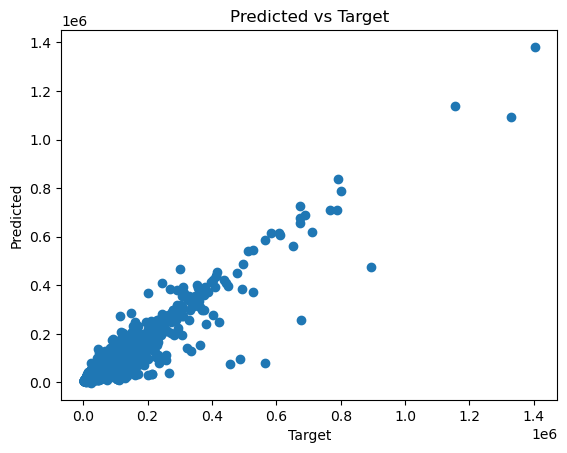

In [9]:
# Show and plot the results
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'R2: {r2_score(y_test, y_pred)}')

plt.scatter(y_test, y_pred)
plt.xlabel('Target')
plt.ylabel('Predicted')
plt.title('Predicted vs Target')
plt.show()

We now make a locally-hosted Web App that predicts the Housing and Water expenditures.

In [14]:
def model_predict(input_arr):
    encoded_input = [input_arr]

    for i in range(len(input_arr)):
        if i == 1:
            encoded_input[0][i] = convert_region[input_arr[i]]
        elif i == 4:
            encoded_input[0][i] = convert_house_type[input_arr[i]]
        elif i == 8:
            encoded_input[0][i] = convert_water_source[input_arr[i]] 

    # Perform polynomial feature transformation if applicable
    input_interactions = poly.fit_transform(encoded_input)

    # Make prediction
    prediction = regressor.predict(input_interactions)

    return prediction[0]

input_arr = [100000, "CAR", 1000, 5, "Single house", 500, 5, 5, "Shared, tubed/piped deep well", 1, 2, 3, 4, 5, 6]
result = model_predict(input_arr)
print(result)

122541.97322317143


In [11]:
# from flask import Flask, render_template, request, jsonify

# # Change based on Saved location
# path = r'C:\Users\Brylle\Desktop\CS180-Project\templates'

# app = Flask(__name__, static_folder = path)

# @app.route('/')
# def index():
#     return render_template('index.html')

# @app.route('/calculate', methods=['POST'])
# def calculate(features=selected_features):
#     input_arr = [int(request.form[x]) for x in features]
#     result = model_predict(features, input_arr)
#     print(result)
#     return jsonify(result=result)

# if __name__ == '__main__':
#     app.run(host='0.0.0.0')